# Causal Inference

Author: Adrian Alarcon

## About

This project wants to use **causal inference** techniques to identify the impact of many variables in the price of a soccer player. Actually, this is a very polemic topic with many controversial opinions. Some people think that there are a difference between right footed players and left footed players, since they say that left footed players are more expensive than right footed players.

In [1]:
## Loading libraries
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error as mse
from scipy.stats import entropy

from causalml.inference.meta import LRSRegressor
from causalml.inference.meta import XGBTRegressor, MLPTRegressor
from causalml.inference.meta import BaseXRegressor, BaseRRegressor, BaseSRegressor, BaseTRegressor
from causalml.inference.tf import DragonNet
from causalml.match import NearestNeighborMatch, MatchOptimizer, create_table_one
from causalml.propensity import ElasticNetPropensityModel
from causalml.dataset.regression import *
from causalml.metrics import *

import seaborn as sns
import warnings

sns.set_theme(style='ticks')
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

/var/folders/3s/3k3nlxhn13nfv9vncl9g9kbr0000gn/T/ipykernel_8277/3179268348.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
Failed to import duecredit due to No module named 'duecredit'


## Data preprocessing

### Read data

In [2]:
data_path = 'https://raw.githubusercontent.com/aladelca/enterprise_data_science/main/data_extract/players_all.csv'
data = pd.read_csv(data_path, index_col=0)
print(data.shape)
data.head()

(5100, 78)


,name,Age,Overall rating,Potential,Team & Contract,ID,Height,Weight,foot,Best overall,Best position,Growth,Joined,Loan date end,Value,Wage,Release clause,Total attacking,Crossing,Finishing,Heading accuracy,Short passing,Volleys,Total skill,Dribbling,Curve,FK Accuracy,Long passing,Ball control,Total movement,Acceleration,Sprint speed,Agility,Reactions,Balance,Total power,Shot power,Jumping,Stamina,Strength,Long shots,Total mentality,Aggression,Interceptions,Att. Position,Vision,Penalties,Composure,Total defending,Defensive awareness,Standing tackle,Sliding tackle,Total goalkeeping,GK Diving,GK Handling,GK Kicking,GK Positioning,GK Reflexes,Total stats,Base stats,Weak foot,Skill moves,Attacking work rate,Defensive work rate,International reputation,Body type,Real face,Pace / Diving,Shooting / Handling,Passing / Kicking,Dribbling / Reflexes,Defending / Pace,Physical / Positioning,Traits,PlayStyles,PlayStyles +,Number of playstyles,Unnamed: 78
0,Vini Jr. LW ST,22,89,94,Real Madrid\n2018 ~ 2027,238794,"176cm / 5'9""",73kg / 161lbs,Right,89,LW,5,"Jul 12, 2018",NaN,€158.5M,€310K,€336.8M,369,78,89,50,80,72,398,92,77,62,77,90,454,95,95,94,86,84,378,76,74,84,64,80,317,58,26,87,81,65,79,75,32,25,18,36,5,7,7,7,10,2027,442,4,5,High,High,5,Lean (170-185),Yes,95,82,78,90,29,68,NaN,Finesse Shot Chip Shot Rapid Flair First Touch...,Quick Step +,7,NaN
1,A. Lunin GK,24,76+2,83+2,Real Madrid\n2018 ~ 2024,243952,"191cm / 6'3""",83kg / 183lbs,Right,76,GK,7,"Jul 2, 2018",NaN,€13M,€67K,€29.3M,72,15,8,12,25,12,81,11,14,15,26,15,210,39,35,36,75+2,25,217,56+2,61+1,32,61,7,131,22,19,11,60,19,56,46,22,13,11,375,76+2,73+2,74+2,75+2,77+2,1132,412,3,1,Medium,Medium,1,Normal (185+),Yes,76,73,74,77,37,75,NaN,Footwork Rush Out,NaN,2,NaN
2,J. Bellingham CAM CM,20,87,92,Real Madrid\n2023 ~ 2029,252371,"186cm / 6'1""",75kg / 165lbs,Right,89,CAM,5,"Jul 1, 2023",NaN,€118.5M,€190K,€251.8M,383,66,86,69,88,74,388,87,73,56,86,86,402,78,76,81,88,79,407,79,80,93,75,80,404,85,82,87,86,64,85,233,77,79,77,48,14,11,10,5,8,2265,486,4,4,High,High,4,Lean (185+),Yes,77,82,81,86,78,82,NaN,Intercept Slide Tackle Technical Flair,Relentless +,5,NaN
3,R. Højlund ST,20,77,89,Manchester United\n2023 ~ 2028,259399,"191cm / 6'3""",79kg / 174lbs,Left,79,ST,12,"Aug 5, 2023",NaN,€25.5M,€77K,€53.6M,325,38,78,70,71+1,68,306,76+1,58,48,49,75-1,380,84,86,69,78+3,63,403,82+4,88,78+3,85,70,322,82+2,28,79+1,63+5,70,75+3,79,32+5,28,19,50,12,8,9,14,7,1865,409,3,3,Medium,High,1,Normal (185+),No,85,76,58,74,33,83,NaN,Rapid Flair Quick Step,NaN,3,NaN
4,K. Havertz CAM RW ST,24,82,87,Arsenal\n2023 ~ 2028,235790,"190cm / 6'3""",82kg / 181lbs,Left,85,CAM,5,"Jun 28, 2023",NaN,€46M,€110K,€88.6M,398,74,81,80,83,80,385,84,84,53,79,85,382,75,81,75,83,68,382,76,82,77,69,78,327,52,38,83,81,73,84,123,39,46,38,47,6,8,11,10,12,2044,432,4,4,Medium,Medium,3,Unique,Yes,78,79,79,83,45,68,NaN,Chip Shot Technical First Touch Trivela,NaN,4,NaN


### Data cleaning

In [3]:
## Constants
FINAL_COLUMNS = [
    'foot',
    'Best position',
    'Defensive work rate',
    'Body type',
    'Traits',
    'PlayStyles',
    'PlayStyles +',
    'club',
    'loan',
    'Age',
    'wage_euros',
    'release_clause_euros',
    'Best overall',
    'Growth',
    'Total attacking',
    'Total skill',
    'Total movement',
    'Total power',
    'Total mentality',
    'Total defending',
    'Total goalkeeping',
    'Total stats',
    'Base stats',
    'Weak foot',
    'Skill moves',
    'International reputation',
    'Pace / Diving',
    'Shooting / Handling',
    'Dribbling / Reflexes',
    'Defending / Pace',
    'Physical / Positioning',
    'Number of playstyles',
    'height_cm',
    'weight_kg',
    'total_potential',
    'contract_duration_years',
    'contract_years_left',
    'total_crossing',
    'total_finishing',
    'total_heading_accuracy',
    'total_short_passing',
    'total_volleys',
    'total_dribbling',
    'total_curve',
    'total_fk_accuracy',
    'total_long_passing',
    'total_ball_control',
    'total_acceleration',
    'total_sprint_speed',
    'total_agility',
    'total_reactions',
    'total_balance',
    'total_shot_power',
    'total_jumping',
    'total_stamina',
    'total_strength',
    'total_long_shots',
    'total_aggression',
    'total_interceptions',
    'total_att__position',
    'total_vision',
    'total_penalties',
    'total_composure',
    'total_defensive_awareness',
    'total_standing_tackle',
    'total_gk_diving',
    'total_gk_handling',
    'total_gk_positioning',
    'total_gk_reflexes',
    'total_overall_rating'
]

columns = [
    'Crossing',
    'Potential',
    'Finishing',
    'Heading accuracy',
    'Short passing',
    'Volleys',
    'Dribbling',
    'Curve',
    'FK Accuracy',
    'Long passing',
    'Ball control',
    'Acceleration',
    'Sprint speed',
    'Agility',
    'Reactions',
    'Balance',
    'Shot power',
    'Jumping',
    'Stamina',
    'Strength',
    'Long shots',
    'Aggression',
    'Interceptions',
    'Att. Position',
    'Vision',
    'Penalties',
    'Composure',
    'Defensive awareness',
    'Standing tackle',
    'GK Diving',
    'GK Handling',
    'GK Kicking',
    'GK Positioning',
    'GK Reflexes',
    'Overall rating'
]

TARGET = [
    'value_euros',
    ]
CAT_VARIABLES = [
    'foot',
    'Best position',
    'Defensive work rate',
    'Body type',
    'Traits',
    'PlayStyles',
    'PlayStyles +',
    'club',
    'loan'
]

NUM_VARIABLES = list(set(FINAL_COLUMNS) - set(CAT_VARIABLES))
index_cat_variables = [FINAL_COLUMNS.index(var) for var in CAT_VARIABLES if var in FINAL_COLUMNS]


In [4]:
### Data cleaning

def get_height(data):
    df_height = data['Height'].str.split('/', expand=True)
    df_height.columns = ['height_cm','height_inch']
    data['height_cm'] = df_height['height_cm'].str.replace('cm','')
    data['height_cm'] = data['height_cm'].astype(int) 
    return data

def get_weight(data):
    df_weight = data['Weight'].str.split('/', expand=True)
    df_weight.columns = ['weight_kg','height_lbs']
    data['weight_kg'] = df_weight['weight_kg'].str.replace('kg','')
    data['weight_kg'] = data['weight_kg'].astype(int) 
    return data

def extract_year(string):
    try:
        match = re.search(r'\b\d{4}\b', string)
        year_extracted = match.group()
        return year_extracted
    except:
        return string

def manage_currency(column_name,final_column_name, data):
    data[column_name] = data[column_name].str.replace('€','')
    data['factor'] = np.where(data[column_name].str.contains('M'),1000000, np.where(data[column_name].str.contains('K'),1000,1))
    data[column_name] = data[column_name].str.replace('M','')
    data[column_name] = data[column_name].str.replace('K','')
    data[column_name] = data[column_name].astype(float)
    data[final_column_name] = data['factor'] * data[column_name]
    return data

def fill_columns(column_name, new_column_name, data):

    df_potential = data[column_name].str.split('[-,+]', expand=True).fillna(0).astype(int)
    data[new_column_name] = df_potential[0] + df_potential[1]
    return data

def get_contract_team_variables(current_year,data):
    df_club = data['Team & Contract'].str.split('\n', expand = True)
    df_club.columns = ['club','contract']
    data['club'] = df_club['club']
    data['loan'] = df_club['contract'].str.contains('On loan')
    df_club['contract_end'] = df_club['contract'].apply(lambda x: extract_year(x) if 'On loan' in x else x)
    df_contract = df_club['contract_end'].str.split('~', expand = True)
    df_contract.columns = ['start','end']
    df_contract['end'] = np.where(df_contract['end'].isna(),df_contract['start'], df_contract['end'])
    data['contract_end'] = df_contract['end']
    data['contract_start'] = data['Joined'].apply(lambda x: extract_year(x))
    data['contract_end'] = data['contract_end'].str.strip()
    data['contract_end'] = np.where(data['contract_end'] == 'Free','', data['contract_end'])
    data['contract_end'] = data['contract_end'].replace('',np.nan)
    data['contract_end'] = data['contract_end'].astype(float)
    data['contract_duration_years'] = data['contract_end'] - data['contract_start'].astype(float)
    data['contract_years_left'] = np.where(data['contract_end'] - 2024>=0, data['contract_end'] - current_year, np.nan)
    return data

def get_total_values(data, columns):
    for i in columns:
        new_column = 'total_'+i.lower()
        new_column = new_column.replace(' ','_')
        new_column = new_column.replace('.','_')
        data = fill_columns(i,new_column,data)
    return data

def get_final_columns(data, columns):
    data = data[columns]
    return data

def data_preprocess(data):
    
    data = get_height(data)
    data = get_weight(data)
    data = manage_currency('Value','value_euros',data)
    data = manage_currency('Wage','wage_euros',data)
    data = manage_currency('Release clause','release_clause_euros',data)
    data = get_contract_team_variables(2024, data)
    data = get_total_values(data, columns)
    data = get_final_columns(data,FINAL_COLUMNS + TARGET)
    return data



In [5]:
df = data_preprocess(data)
df.head()

,foot,Best position,Defensive work rate,Body type,Traits,PlayStyles,PlayStyles +,club,loan,Age,wage_euros,release_clause_euros,Best overall,Growth,Total attacking,Total skill,Total movement,Total power,Total mentality,Total defending,Total goalkeeping,Total stats,Base stats,Weak foot,Skill moves,International reputation,Pace / Diving,Shooting / Handling,Dribbling / Reflexes,Defending / Pace,Physical / Positioning,Number of playstyles,height_cm,weight_kg,total_potential,contract_duration_years,contract_years_left,total_crossing,total_finishing,total_heading_accuracy,total_short_passing,total_volleys,total_dribbling,total_curve,total_fk_accuracy,total_long_passing,total_ball_control,total_acceleration,total_sprint_speed,total_agility,total_reactions,total_balance,total_shot_power,total_jumping,total_stamina,total_strength,total_long_shots,total_aggression,total_interceptions,total_att__position,total_vision,total_penalties,total_composure,total_defensive_awareness,total_standing_tackle,total_gk_diving,total_gk_handling,total_gk_positioning,total_gk_reflexes,total_overall_rating,value_euros
0,Right,LW,High,Lean (170-185),NaN,Finesse Shot Chip Shot Rapid Flair First Touch...,Quick Step +,Real Madrid,False,22,310000.0,336800000.0,89,5,369,398,454,378,317,75,36,2027,442,4,5,5,95,82,90,29,68,7,176,73,94,9.0,3.0,78,89,50,80,72,92,77,62,77,90,95,95,94,86,84,76,74,84,64,80,58,26,87,81,65,79,32,25,5,7,7,10,89,158500000.0
1,Right,GK,Medium,Normal (185+),NaN,Footwork Rush Out,NaN,Real Madrid,False,24,67000.0,29300000.0,76,7,72,81,210,217,131,46,375,1132,412,3,1,1,76,73,77,37,75,2,191,83,85,6.0,0.0,15,8,12,25,12,11,14,15,26,15,39,35,36,77,25,58,62,32,61,7,22,19,11,60,19,56,22,13,78,75,77,79,78,13000000.0
2,Right,CAM,High,Lean (185+),NaN,Intercept Slide Tackle Technical Flair,Relentless +,Real Madrid,False,20,190000.0,251800000.0,89,5,383,388,402,407,404,233,48,2265,486,4,4,4,77,82,86,78,82,5,186,75,92,6.0,5.0,66,86,69,88,74,87,73,56,86,86,78,76,81,88,79,79,80,93,75,80,85,82,87,86,64,85,77,79,14,11,5,8,87,118500000.0
3,Left,ST,High,Normal (185+),NaN,Rapid Flair Quick Step,NaN,Manchester United,False,20,77000.0,53600000.0,79,12,325,306,380,403,322,79,50,1865,409,3,3,1,85,76,74,33,83,3,191,79,89,5.0,4.0,38,78,70,72,68,77,58,48,49,76,84,86,69,81,63,86,88,81,85,70,84,28,80,68,70,78,37,28,12,8,14,7,77,25500000.0
4,Left,CAM,Medium,Unique,NaN,Chip Shot Technical First Touch Trivela,NaN,Arsenal,False,24,110000.0,88600000.0,85,5,398,385,382,382,327,123,47,2044,432,4,4,3,78,79,83,45,68,4,190,82,87,5.0,4.0,74,81,80,83,80,84,84,53,79,85,75,81,75,83,68,76,82,77,69,78,52,38,83,81,73,84,39,46,6,8,10,12,82,46000000.0


(5100, 71)


<Axes: title={'center': 'Percentage of null values'}>

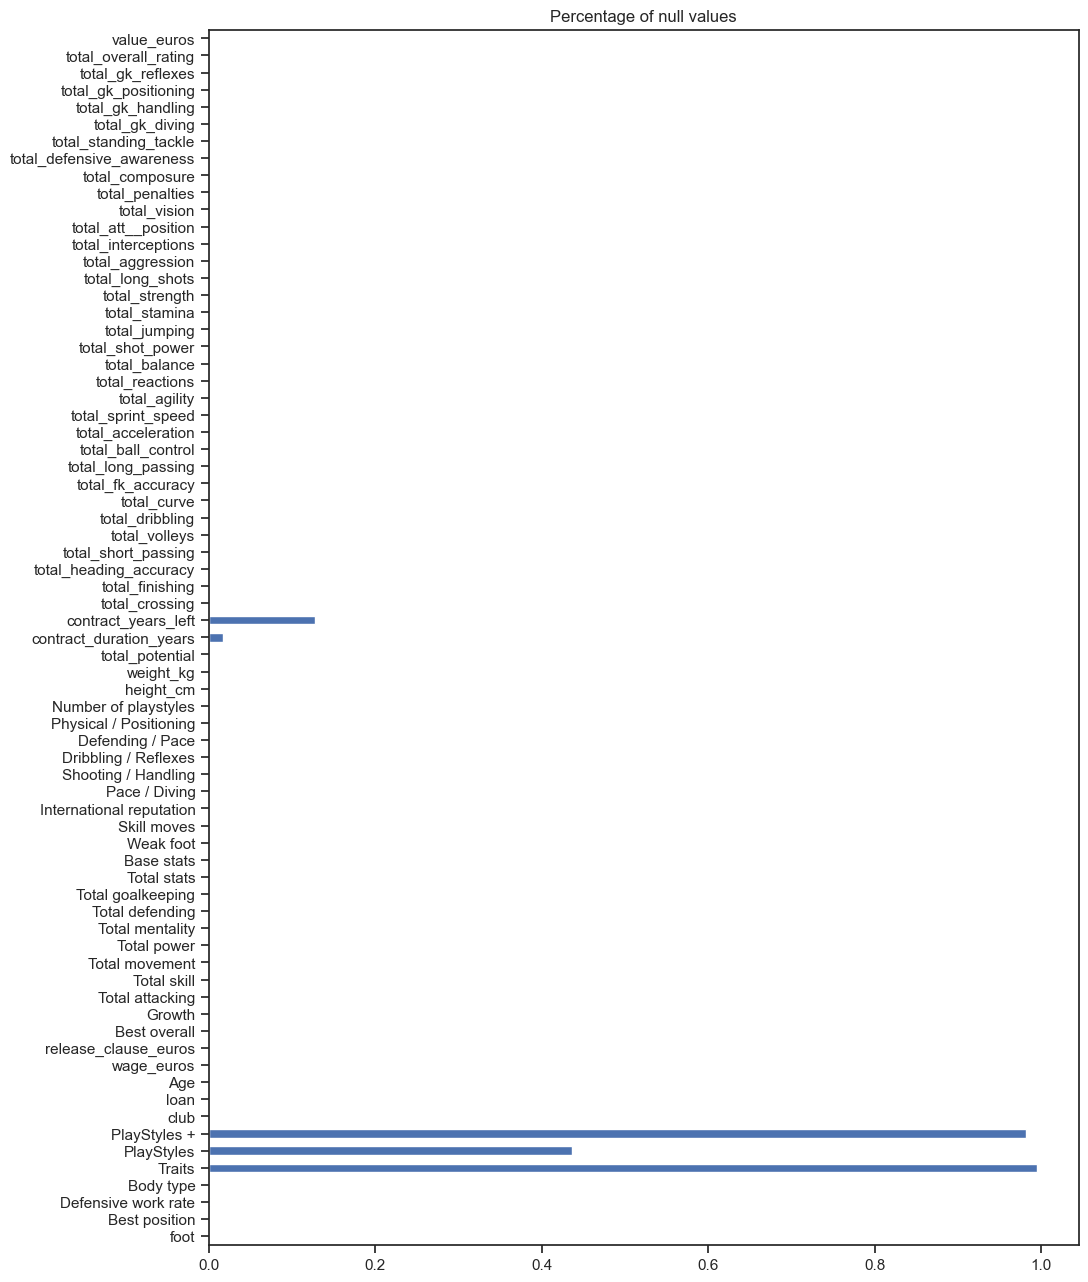

In [13]:
print(df.shape)
plt.figure(figsize=(10,15))
plt.title('Percentage of null values')
df.isna().mean().plot(kind='barh')

In [14]:
## Removing null values from contract_years_left column
df = df[~df['contract_years_left'].isna()]

## Exploratory Data Analysis

In [15]:
print(df[['Total stats','Age','Best overall','value_euros']].corr())


              Total stats       Age  Best overall  value_euros
Total stats      1.000000  0.350900      0.683441     0.434206
Age              0.350900  1.000000      0.511795     0.190106
Best overall     0.683441  0.511795      1.000000     0.675390
value_euros      0.434206  0.190106      0.675390     1.000000


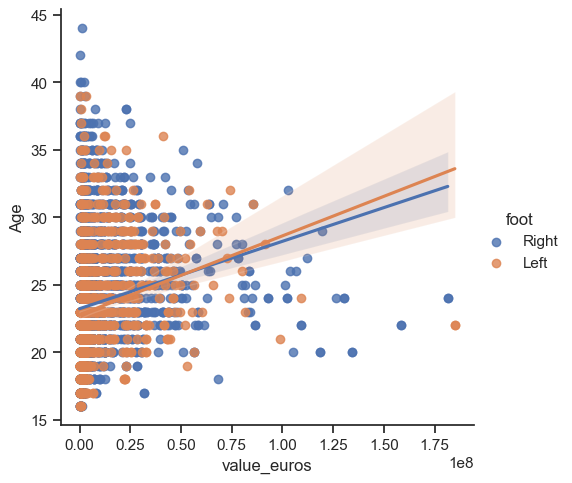

In [16]:
sns.lmplot(
    data = df, 
    x = 'value_euros',
    y = 'Age',
    hue = 'foot'
    )
plt.show()

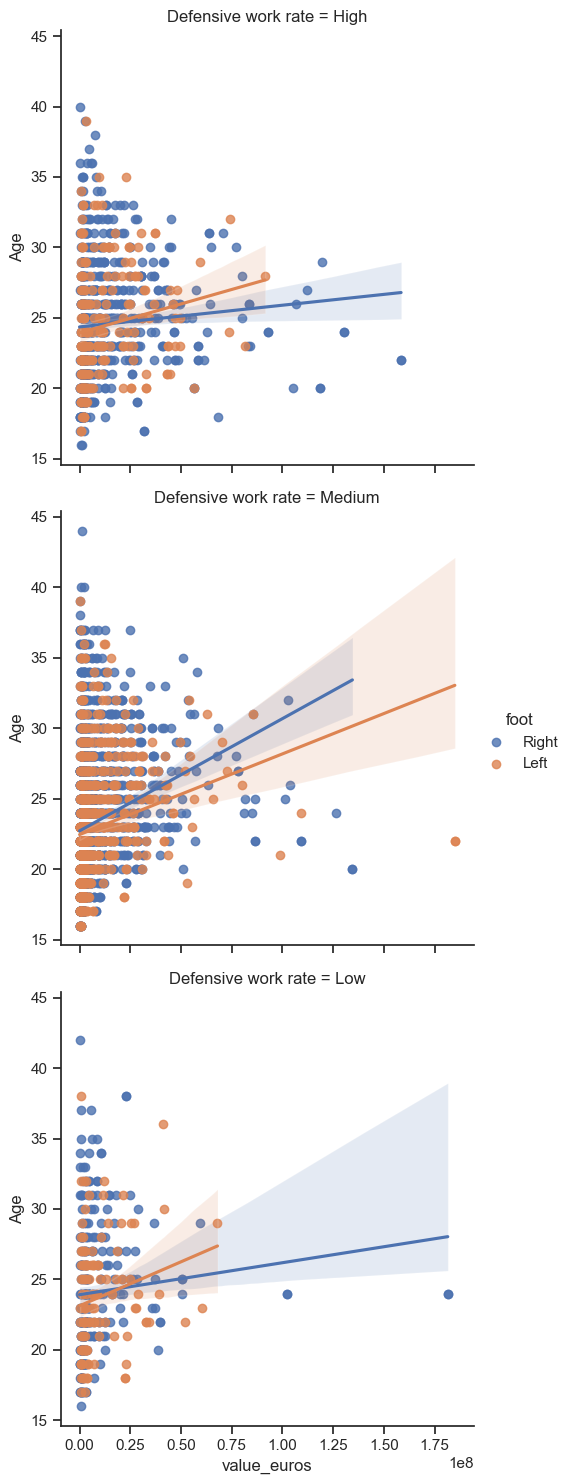

In [17]:
sns.lmplot(
    data = df, 
    x = 'value_euros',
    y = 'Age',
    col = 'Defensive work rate',
    hue = 'foot',
    col_wrap = 1
    )
plt.show()

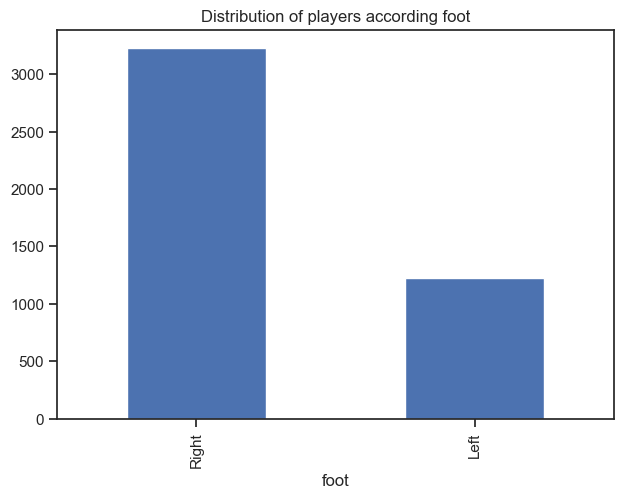

In [19]:
df['foot'].value_counts().plot(kind='bar')
plt.title('Distribution of players according foot')
plt.show()

## Causal inference

In [20]:
## Variables

y = df[TARGET].values.reshape(df.shape[0],)
x = df.loc[:,~df.columns.isin(['foot']+TARGET)][NUM_VARIABLES]
df['treatment'] = np.where(df['foot']=='Right',0,1)
treatment = df['treatment'].values


In [21]:
p_model = ElasticNetPropensityModel()
p = p_model.fit_predict(x, treatment)

In [22]:
s_learner = BaseSRegressor(LGBMRegressor())
s_ate = s_learner.estimate_ate(x, treatment, y)
s_ite = s_learner.fit_predict(x, treatment, y)

t_learner = BaseTRegressor(LGBMRegressor())
t_ate = t_learner.estimate_ate(x, treatment, y)[0][0]
t_ite = t_learner.fit_predict(x, treatment, y)

x_learner = BaseXRegressor(LGBMRegressor())
x_ate = x_learner.estimate_ate(x, treatment, y, p)[0][0]
x_ite = x_learner.fit_predict(x, treatment, y, p)

r_learner = BaseRRegressor(LGBMRegressor())
r_ate = r_learner.estimate_ate(x, treatment, y, p)[0][0]
r_ite = r_learner.fit_predict(x, treatment, y, p)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000891 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5477
[LightGBM] [Info] Number of data points in the train set: 4447, number of used features: 62
[LightGBM] [Info] Start training from score 8372998.650776
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000990 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5477
[LightGBM] [Info] Number of data points in the train set: 4447, number of used features: 62
[LightGBM] [Info] Start training from score 8372998.650776
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000654 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5386
[LightGBM] [Info] Number of data points in the

In [124]:
dragon = DragonNet(neurons_per_layer=200, targeted_reg=True)
dragon_ite = dragon.fit_predict(x, treatment, y, return_components=False)
dragon_ate = dragon_ite.mean()

Epoch 1/30
56/56 [==============================] - 1s 5ms/step - loss: 10255649610924032.0000 - regression_loss: 5089626440073216.0000 - binary_classification_loss: 121.8285 - treatment_accuracy: 0.7226 - track_epsilon: 0.0452 - val_loss: 147334054805504.0000 - val_regression_loss: 74422589325312.0000 - val_binary_classification_loss: 116.0302 - val_treatment_accuracy: 0.7361 - val_track_epsilon: 0.0540 - lr: 0.0010
Epoch 2/30
56/56 [==============================] - 0s 3ms/step - loss: 1553595837186048.0000 - regression_loss: 773202091442176.0000 - binary_classification_loss: 121.8285 - treatment_accuracy: 0.7230 - track_epsilon: 0.0586 - val_loss: 112626172428288.0000 - val_regression_loss: 56933339889664.0000 - val_binary_classification_loss: 116.0302 - val_treatment_accuracy: 0.7361 - val_track_epsilon: 0.0636 - lr: 0.0010
Epoch 3/30
56/56 [==============================] - 0s 3ms/step - loss: 1114067540377600.0000 - regression_loss: 553180513435648.0000 - binary_classification_lo

Epoch 1/100
139/139 [==============================] - 0s 673us/step


In [126]:
dragon_ite

array([[nan],
       [nan],
       [nan],
       ...,
       [nan],
       [nan],
       [nan]], dtype=float32)

In [112]:
df_preds = pd.DataFrame([s_ite.ravel(),
                          t_ite.ravel(),
                          x_ite.ravel(),
                          r_ite.ravel(),
                          dragon_ite.ravel(),
                          treatment.ravel(),
                          y.ravel()],
                       index=['S','T','X','R','dragonnet','w','y']).T

df_cumgain = get_cumgain(df_preds)

In [117]:
df_result = pd.DataFrame([s_ate, t_ate, x_ate, r_ate, dragon_ate],
                     index=['S','T','X','R','dragonnet'], columns=['ATE'])

df_result

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/aladelca/anaconda3/envs/causal_inference/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3550, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/3s/3k3nlxhn13nfv9vncl9g9kbr0000gn/T/ipykernel_7402/466297627.py", line 1, in <module>
    df_result = pd.DataFrame([s_ate, t_ate, x_ate, r_ate, dragon_ate],
  File "/Users/aladelca/anaconda3/envs/causal_inference/lib/python3.9/site-packages/pandas/core/frame.py", line 694, in __init__
  File "/Users/aladelca/anaconda3/envs/causal_inference/lib/python3.9/site-packages/pandas/core/internals/construction.py", line 483, in nested_data_to_arrays
    if copy:
  File "/Users/aladelca/anaconda3/envs/causal_inference/lib/python3.9/site-packages/pandas/core/internals/construction.py", line 804, in to_arrays
    This will become frame.columns.
  File "/Users/aladelca/anaconda3/envs/causal_inference/lib/python3.9/site-packages/pandas/core/internals/c

In [26]:
lr = LRSRegressor()
te, lb, ub = lr.estimate_ate(x,treatment,y)
print(te[0])
print(lb[0])
print(y[0])

46569.58199800633
-134170.96325063726
158500000.0


In [29]:
xg = XGBTRegressor(random_estate = 123)
te, lb, ub = xg.estimate_ate(x, treatment, y)
print(te[0])
print(lb[0])
print(y[0])

-119054.3620795972
-214021.26829803118
158500000.0
